
Using the SQL database approach, compare manta data with model results, varying
the averaging period and the max age.

**v01:** try adapting this to each category separately, see if the model shows difference in loss rates.


Manta data is already adjusted by category, and the category-level data is in the csv.

Load data...

In [21]:
import os
import time
from collections import defaultdict
import six

import logging as log
import glob
import re

from matplotlib import colors, cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import LogNorm

import numpy as np

import pandas as pd
import xarray as xr

from sqlite3 import dbapi2 as sql

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.spatial import proj_utils 
from stompy.model.data_comparison import calc_metrics
from stompy.plot import plot_wkb
from stompy.model import data_comparison
import stompy.plot.cmap as scmap

import postprocess_v00 as post

%matplotlib notebook

In [22]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')

In [23]:
# Load the manta data, clean it up
manta=pd.read_csv('manta_summary-v02.csv')
manta.head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,CB-4-Manta-21Aug2017,CB4,2017-08-21 00:00:00,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21 00:00:00,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21 00:00:00,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21 00:00:00,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,CB9-Manta-22Aug2017,CB9,2017-08-22 00:00:00,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [24]:
manta.columns

Index(['SampleID', 'SAMPLE LOCATION', 'DATE', 'TYPE', 'LAT START',
       'LONG START', 'LAT END', 'LONG END', 'TOTAL DIST (M)', 'START FLOW',
       'END FLOW', 'area_km2', 'volume_m3', 'FibersYN', 'Season', 'time_pt',
       'time_local', 'time_utc', 'lat', 'lon', 'volume_l', 'area_m2',
       'count_preblank_std', 'count_preblank_nofiber', 'Fiber', 'Fiber Bundle',
       'Film', 'Foam', 'Fragment', 'Sphere', 'Fiber_adj', 'Fiber Bundle_adj',
       'Fragment_adj', 'Foam_adj', 'Film_adj', 'Sphere_adj', 'count_std',
       'count_nofiber', 'part_per_m3_std', 'part_per_m2_std',
       'part_per_m3_raw_std', 'part_per_m2_raw_std', 'part_per_m3_nofiber',
       'part_per_m2_nofiber', 'part_per_m3_raw_nofiber',
       'part_per_m2_raw_nofiber', 'x', 'y'],
      dtype='object')

In [70]:
import sql_common
six.moves.reload_module(sql_common)

# try to run everything that can be cached and re-used through
# here. 

<module 'sql_common' from '/home/rusty/src/microplastic_sfbay/postprocess/sql_common.py'>

In [71]:
#PtmSet=sql_common.PtmSet
#dbs=glob.glob("/opt2/sfb_ocean/ptm/all_source/*/ptm_and_grid.db")

PtmSet=sql_common.PtmSetNew
dbs=glob.glob("/opt2/sfb_ocean/ptm/all_source_020b/20*/ptm_and_grid.db")

dbs.sort()

ptm_set=PtmSet(databases=dbs)

In [72]:
con=ptm_set.db_to_con(ptm_set.databases[1])

curs=con.cursor()

In [28]:
# For each trawl, I want to query all of the particles 
# that were "nearby" at a "near time", and get their
# release time, cell, std mass, and nofiber mass.
# from there, it's postprocessing to see what subset or
# weighting of those gives the best agreement with
# part_per_m2_std and part-per_m2_raw

In [73]:
# Is it possible to run the query once, and save enough info about the
# particles to apply loading scenarios after the fact?

def query_particles(t_start,t_stop,
                    z_filter="and loc.z_from_surface>-0.2",
                    max_age=np.timedelta64(20,'D'), # could go to 30
                    grp_filter=""):
    epoch_start=int( utils.to_unix( t_start ) )
    epoch_stop =int( utils.to_unix( t_stop ) )
    max_age_clause=f"and (loc.time-rel.time)<{int(max_age/np.timedelta64(1,'s'))}"

    # Start with a global query -- how long does it take, and how
    # many rows?
    # So rather than multiplying out the loads here, 
    # record rel.volume/rel.count to get rel_part_volume
    # 
    query=f"""
      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>={epoch_start} and loc.time < {epoch_stop}
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0
          {max_age_clause}
          {z_filter}
          {grp_filter}"""
    print(query)    
    
    query_dtype=[('rel_part_volume',np.float64),
                 ('time',np.int32),
                 ('rel_time',np.int32),
                 ('cell',np.int32),
                 ('group','U100')]

    all_data=[]
    all_data.append( np.zeros(0,dtype=query_dtype) )

    for db in ptm_set.databases:
        con=ptm_set.db_to_con(db)
        curs=con.cursor()
        curs.execute(query)
        data=curs.fetchall()
        print(f"{db} {len(data)} rows")
        if len(data)==0: continue
        adata=np.array(data)

        adata2=np.zeros(len(adata),dtype=query_dtype)
        adata2['rel_part_volume']=adata[:,0]
        adata2['time']=adata[:,1].astype(np.int32)
        adata2['rel_time']=adata[:,2].astype(np.int32)
        adata2['cell']=adata[:,3].astype(np.int32)
        adata2['group']=adata[:,4]
        all_data.append(adata2)

    combined=np.concatenate( all_data )
    return combined


In [74]:
res=query_particles(t_start=np.datetime64("2017-11-04 12:00:00"),
                    t_stop =np.datetime64("2017-11-04 13:00:00"),
                    max_age=np.timedelta64(1,'D'))



      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>=1509796800 and loc.time < 1509800400
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0
          and (loc.time-rel.time)<86400
          and loc.z_from_surface>-0.2
          
/opt2/sfb_ocean/ptm/all_source_020b/20170720/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170730/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170809/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170819/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170829/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170908/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source

In [75]:
# Load the loads
loads=xr.open_dataset("../loads/plastic_loads-7classes-v05.nc")
loads

<xarray.Dataset>
Dimensions:            (category: 6, pathway: 2, source: 9, w_s: 7)
Coordinates:
  * pathway            (pathway) object 'effluent' 'stormwater'
  * category           (category) object 'Fiber' 'Fiber Bundle' ... 'Sphere'
  * w_s                (w_s) float64 -0.05 -0.005 -0.0005 0.0 0.0005 0.005 0.05
  * source             (source) object 'CCCSD' 'EBDA' ... 'SUNN' 'stormwater'
Data variables:
    n_blank_particles  (pathway, category) int64 ...
    n_blank_samples    (pathway, category) int64 ...
    blank_rate         (pathway, category) float64 ...
    total_volume       (source) float64 ...
    n_samples          (source) float64 ...
    count_w_s          (source, category, w_s) int32 ...
    count_no_w_s       (source, category) int32 ...
    conc_raw           (source, category, w_s) float64 ...
    source_pathway     (source) object ...
    conc               (source, category, w_s) float64 ...
    conc_noclip        (source, category, w_s) float64 ...
    conc_

In [76]:
load_all_cat=loads.conc.sum(dim='category')
load_all_cat

<xarray.DataArray 'conc' (source: 9, w_s: 7)>
array([[6.009615e-03, 2.326170e-02, 1.024659e-02, 0.000000e+00, 2.031638e-02,
        7.184657e-03, 3.928867e-03],
       [1.407841e-03, 1.477795e-03, 1.678915e-03, 0.000000e+00, 2.115434e-02,
        5.676026e-03, 3.874420e-04],
       [1.205560e-02, 4.124285e-02, 6.577387e-03, 0.000000e+00, 1.747284e-02,
        1.265562e-02, 1.272460e-03],
       [0.000000e+00, 4.466818e-04, 1.509197e-04, 0.000000e+00, 2.149446e-03,
        1.191045e-03, 1.843449e-04],
       [0.000000e+00, 1.487029e-04, 3.561745e-05, 0.000000e+00, 3.231319e-03,
        2.820976e-03, 4.986443e-05],
       [5.271378e-03, 5.273754e-02, 3.038566e-02, 0.000000e+00, 5.833155e-02,
        2.362963e-02, 2.651434e-03],
       [1.739736e-03, 7.495429e-03, 2.068292e-03, 1.164285e-03, 4.175365e-03,
        3.433315e-03, 4.103992e-04],
       [2.314815e-04, 2.777778e-04, 5.555556e-04, 0.000000e+00, 5.681818e-03,
        5.290404e-03, 0.000000e+00],
       [2.611561e-02, 2.439931e-01

In [90]:
# res: released_part_volume particles/m3, time of observation, release_time, cell index,
# and the group.
# loads: source, category, w_s => particles/l
# Note that wastewater should be scaled up by 1/0.70
# stormwater is maybe close enough now that there are so many sources.
behavior_to_ws=sql_common.behavior_to_ws                                                                                                                   

source_map=defaultdict(lambda:'stormwater')                                                                                                                
source_map['cccsd']='CCCSD'                                                                                                                                
source_map['sunnyvale']='SUNN'                                                                                                                             
source_map['fs']='FSSD'                                                                                                                                    
source_map['palo_alto']='PA'                                                                                                                               
source_map['san_jose']='SJ'                                                                                                                                
source_map['src000']='EBDA'                                                                                                                                
source_map['src001']='EBMUD'                                                                                                                               
source_map['src002']='SFPUC'                                                                                                                               

# these we don't actually use                                                                                                                              
source_map['petaluma']='SKIP'                                                                                                                              

# These shouldn't be used, but including just to be sure                                                                                                   
# that if they somehow show up, they won't contaminate                                                                                                     
# stormwater.                                                                                                                                              
source_map['SacRiver']='DELTA'                                                                                                                             
source_map['SJRiver']='DELTA'                                                                                                                              

def particle_weight_mapping(load_da,res,wastewater_scale=1/0.70,stormwater_scale=1.0):
    # Here generate a mapping of group to release particle/m3.
    # tuples of group_name, particles/m3.                                                                                                                      
    # can omit rows with 0 concentration.                                                                                                                      
    group_names=np.unique(res['group'])
    # numpy strings have to be preallocated at max string length.
    # thus U100
    mapping=np.zeros(len(group_names),
                     dtype=[('group','U100'),('conc',np.float64)])
    mapping['group'][:]=group_names
    
    for grp_i, group_name in enumerate(group_names):
        # group ~ Source_Name_behavior_relYYYYMMDD
        m=re.match(r'(.*)_(down\d+|up\d+|none)(_rel.*)?',group_name)                                                                                         
        source=m.group(1)  
        behavior=m.group(2)
        rel_time=m.group(3) # may be missing
        w_s=behavior_to_ws[behavior]                                                                                                                           

        source_name=source_map[source]                                                                                                                         
        if source_name in ['DELTA','SKIP']:                                                                                                                    
            conc=0.0                                                                                                                              
        else:                                                                                                                                                  
            conc=load_da.sel(source=source_name,w_s=w_s).item()                                                                                           

        if source_name=='stormwater':                                                                                                
            conc*=stormwater_scale                                                                                                                             
        else:                                                                                                                                                  
            conc*=wastewater_scale                                                                                                                             

        # load netcdf is in particles/l, but we want to set the calculation                                                                                    
        # up as particle/m3. Updated 2019-11-17                                                                                                                
        conc*=1000                                                                                                                                                                                                                                                                                       
        mapping['conc'][grp_i]=conc
        print(f"{source:15s}  {behavior:9s} => {source_name:15s} {conc:.4f}")
    return mapping

def particle_counts_from_load(res,load_da,**kw):
    """
    load_da: xr.DataArray giving microparticle/m3 load concentrations
    by source and w_s.
    res: numpy struct array with group: <Source>_<w_s>_<release date>
      and rel_part_volume: the inflow volume represented by each PTM particle.
    return an array, same size as res, giving the inflow count of microparticles
      for each PTM particle. 
    """
    mapping=particle_weight_mapping(load_all_cat,res,**kw)
    grp_idx=np.searchsorted(mapping['group'],res['group'])
    # this assertion can be dropped soon.
    assert np.all(mapping['group'][grp_idx]==res['group'])

    # microparticles/m3 in the release for each PTM particle
    load_conc=mapping['conc'][grp_idx]
    # microparticles/PTM particle.
    load_particles=load_conc * res['rel_part_volume']
    return load_particles


In [67]:
out_dir="manta_sets_20200212a"
# updated vertical, but still 020b data.
# so an undercount. but 
os.makedirs(out_dir,exist_ok=True)

for idx,rec in manta.iterrows():
    #fn=os.path.join(out_dir,f"{rec.SampleID}.npy")
    # since we're just pulling out whole days, cache by day.
    # and pull through the end of that day
    fn=os.path.join(out_dir,f"v01-{rec.DATE[:10]}.npy")
    
    if os.path.exists(fn):
        print(f"{fn} exists. Skipping")
        continue

    # pull a generous buffer of particles here, and narrow
    if 1:
        t_sample=np.datetime64(rec.DATE)
        # want to be able to, after the fact, query a full 25h tidal cycle
        # centered on the actual time of a sample that could fall anywhere
        # in this day.
        t_start=t_sample+np.timedelta64(8,'h') - np.timedelta64(12,'h')
        # and go for a tidal day
        t_stop =t_sample+np.timedelta64(8+24,'h') + np.timedelta64(13,'h')
        query_n_steps=25 # how many hours are included in the query.
        
    combined=query_particles(t_start,t_stop)
    np.save(fn,combined)



      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>=1503259200 and loc.time < 1503435600
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0
          and (loc.time-rel.time)<1728000
          and loc.z_from_surface>-0.2
          
/opt2/sfb_ocean/ptm/all_source_020b/20170720/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170730/ptm_and_grid.db 1060995 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170809/ptm_and_grid.db 1483504 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170819/ptm_and_grid.db 535271 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170829/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170908/ptm_and_grid.db 0 rows
/opt2/sfb_o

/opt2/sfb_ocean/ptm/all_source_020b/20170730/ptm_and_grid.db 613849 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170809/ptm_and_grid.db 1452589 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170819/ptm_and_grid.db 1050379 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170829/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170908/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170918/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170928/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171008/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171018/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171028/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171107/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171117/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171127/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171207/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_

manta_sets_20200212a/v01-2017-09-12.npy exists. Skipping
manta_sets_20200212a/v01-2017-09-12.npy exists. Skipping
manta_sets_20200212a/v01-2017-09-12.npy exists. Skipping

      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>=1505246400 and loc.time < 1505422800
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0
          and (loc.time-rel.time)<1728000
          and loc.z_from_surface>-0.2
          
/opt2/sfb_ocean/ptm/all_source_020b/20170720/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170730/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170809/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20170819/ptm_and_grid.db 

/opt2/sfb_ocean/ptm/all_source_020b/20171008/ptm_and_grid.db 144454 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171018/ptm_and_grid.db 1384819 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171028/ptm_and_grid.db 1490599 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171107/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171117/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171127/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171207/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171217/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171227/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180106/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180116/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180126/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180205/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180215/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_

/opt2/sfb_ocean/ptm/all_source_020b/20171217/ptm_and_grid.db 774424 rows
/opt2/sfb_ocean/ptm/all_source_020b/20171227/ptm_and_grid.db 1990633 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180106/ptm_and_grid.db 1339457 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180116/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180126/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180205/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180215/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180225/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180307/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180317/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180327/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180406/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180416/ptm_and_grid.db 0 rows
manta_sets_20200212a/v01-2018-01-11.npy exists. Skipping
manta_sets_20200212a/v01-2018-01-11.npy ex

/opt2/sfb_ocean/ptm/all_source_020b/20180307/ptm_and_grid.db 1096901 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180317/ptm_and_grid.db 1640323 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180327/ptm_and_grid.db 605309 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180406/ptm_and_grid.db 0 rows
/opt2/sfb_ocean/ptm/all_source_020b/20180416/ptm_and_grid.db 0 rows
manta_sets_20200212a/v01-2018-03-29.npy exists. Skipping
manta_sets_20200212a/v01-2018-03-29.npy exists. Skipping
manta_sets_20200212a/v01-2018-03-29.npy exists. Skipping

      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>=1522353600 and loc.time < 1522530000
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0

In [78]:
g=ptm_set.grid()

In [79]:
# just preload all of the particle data:
# going to use a good bit of memory...
@memoize.memoize()
def load_particles(date):
    particle_fn=os.path.join(out_dir,f"v01-{date[:10]}.npy")
    particles=np.load(particle_fn)
    return particles

In [80]:
@memoize.memoize()
def stencil0(c):
    stencil=np.zeros(g.Ncells(),np.float64)
    stencil[c]=1.0
    return stencil

@memoize.memoize()
def stencil1(c):
    return ptm_set.smooth(stencil0(c))
   

In [91]:
import time

# which particles will be counted relative to the time of the manta
# observation itself.
vers='20200212d' # 25 h, centered on sample
hours_min=-12
hours_max= 13

# previous attempts
#vers='20191205e' # 6 h, centered on sample. not as clear, but 1d is still the winner.
#hours_min=-3
#hours_max= 3

#vers='20191205f' # 4 h, centered on sample. not great, and 0.5d is the winner.
#hours_min=-2
#hours_max= 2

def extract_for_sample(rec,load_da,smooth=0,tau_s=-1):
    """
    rec: a DataFrame row from the manta data
    load_da: xr.DataArray with particle/m3 load concentrations by source, w_s.
    """
    t0=time.time()
    def tok(msg=''):
        print(f"{msg} elapsed {time.time()-t0}")
        
    particles=load_particles(rec.DATE)
    # This is where a different wastewater_scale or stormwater_scale
    # could be supplied
    load_counts=particle_counts_from_load(particles,load_da)
    
    age_s=particles['time']-particles['rel_time']
    if tau_s>0:
        aged_counts=np.exp(-age_s/tau_s) * load_counts
    else:
        aged_counts=load_counts
    
    # time of observation relative to the time of the manta sample.
    relative_time_h=(particles['time']-utils.to_unix(rec.time_utc))/3600.0
    aged_counts[relative_time_h<hours_min]=0.0
    aged_counts[relative_time_h>hours_max]=0.0
    nsteps=hours_max-hours_min
    
    cell_counts=np.bincount( particles['cell'], weights=aged_counts,
                             minlength=g.Ncells())
    # This sets the units -- particles per m2
    cell_conc=cell_counts/g.cells_area()/nsteps

    c_select=ptm_set.grid().select_cells_nearest(np.r_[rec.x,rec.y])
    stencil=stencil0(c_select)
    M=ptm_set.Msmooth()
    for s in range(smooth):
        stencil=M.dot(stencil)
    conc=(stencil*cell_conc).sum()
    return conc

In [92]:
manta_field='part_per_m2_std'
load_da=loads.conc.sum(dim='category')

In [93]:
rec=manta.iloc[0,:]
particles=load_particles(rec.DATE)
particles

array([(235.42343428, 1503259200, 1501542000, 3062, 'Alameda_Creek_down5000_rel20170730'),
       (235.42343428, 1503259200, 1501542000, 3075, 'Alameda_Creek_down5000_rel20170730'),
       (238.54111913, 1503259200, 1501545600, 3039, 'Alameda_Creek_down5000_rel20170730'),
       ...,
       (315.72480817, 1503432000, 1503406800, 3777, 'sunnyvale_up500_rel20170819'),
       (316.60325153, 1503432000, 1503410400, 3794, 'sunnyvale_up500_rel20170819'),
       (319.23858158, 1503432000, 1503421200, 3808, 'sunnyvale_up500_rel20170819')],
      dtype=[('rel_part_volume', '<f8'), ('time', '<i4'), ('rel_time', '<i4'), ('cell', '<i4'), ('group', '<U100')])

In [ ]:
smooths=[0,1,2,3,4,5,10,15,20]
taus=np.array([0.5,1,2,3,4,5,10,15,20]) * 86400.
all_results=[]
for smooth in smooths:
    for tau in taus:
        # 1 or 2 smooth makes a big improvement in spearman.
        # nothing helps r, bias or amp.
        pred=manta.apply(lambda rec: extract_for_sample(rec,load_da=load_da,smooth=smooth,tau_s=tau),
                         axis=1)
        obs=manta['part_per_m2_std']

        metrics=calc_metrics( xr.DataArray(pred), xr.DataArray(obs))
        metrics['smooth']=smooth
        metrics['tau']=tau
        metrics['dataset']='nofiber'
        
        metrics['log_r']=np.corrcoef( np.log10(pred.clip(1e-6)), np.log10(obs.clip(1e-6)))[1,0]
        all_results.append(metrics)
        

In [140]:
df=pd.DataFrame(all_results)
df.to_csv(f"parameter-scan-{vers}.csv")

In [141]:
df=pd.read_csv(f'parameter-scan-{vers}.csv')
df['tau_d']=df.tau/86400.

In [142]:
import seaborn as sns

<IPython.core.display.Javascript object>


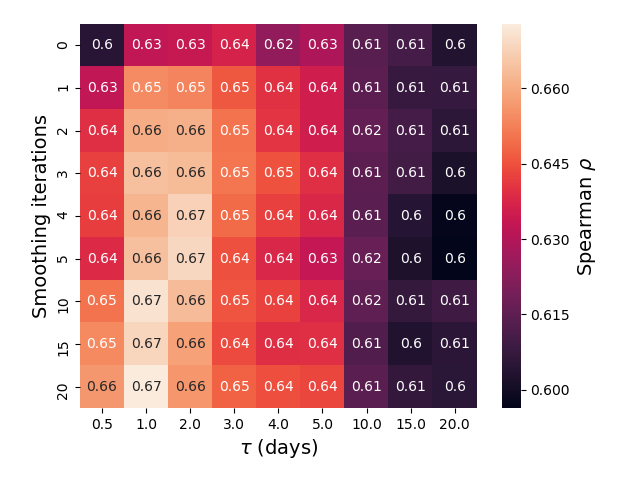

In [143]:
field='spearman_rho'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

fig,ax=plt.subplots(1,1)
hm=sns.heatmap(as_matrix, annot=True)
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
ax.set_ylabel('Smoothing iterations',fontsize=14)
cax=fig.axes[1]
cax.set_ylabel(r'Spearman $\rho$',fontsize=14)
plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
fig.savefig(f'manta_compare_spearman_rho-{vers}.png',dpi=150)

<IPython.core.display.Javascript object>


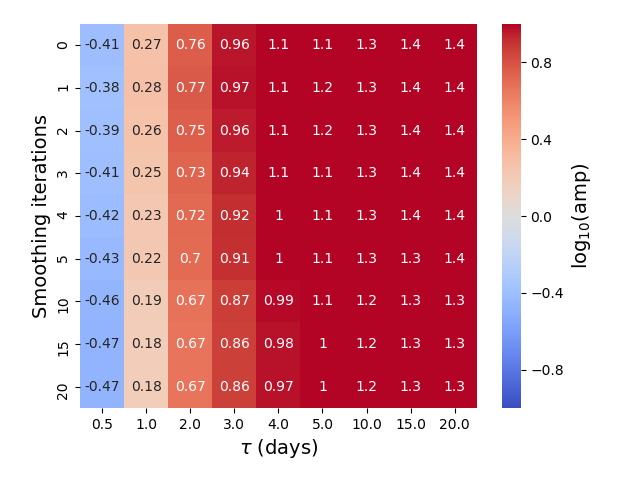

In [144]:
df['log_amp']=np.log10(df.amp)
field='log_amp'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

fig,ax=plt.subplots(1,1)

hm=sns.heatmap(as_matrix, annot=True,cmap='coolwarm',ax=ax,
               cbar_kws=dict(label=field),vmin=-1,vmax=1)
plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
ax.set_ylabel('Smoothing iterations',fontsize=14)
cax=fig.axes[1]
cax.set_ylabel('log$_{10}$(amp)',fontsize=14)
fig.savefig(f'manta_compare_log10amp-{vers}.png',dpi=150)


<IPython.core.display.Javascript object>


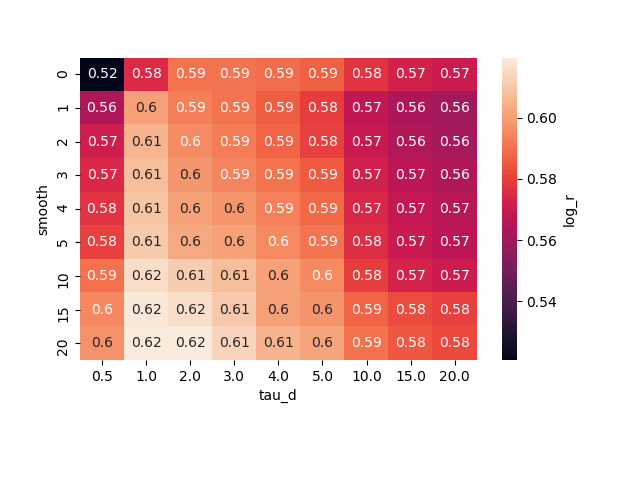

In [145]:
field='log_r'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

<IPython.core.display.Javascript object>


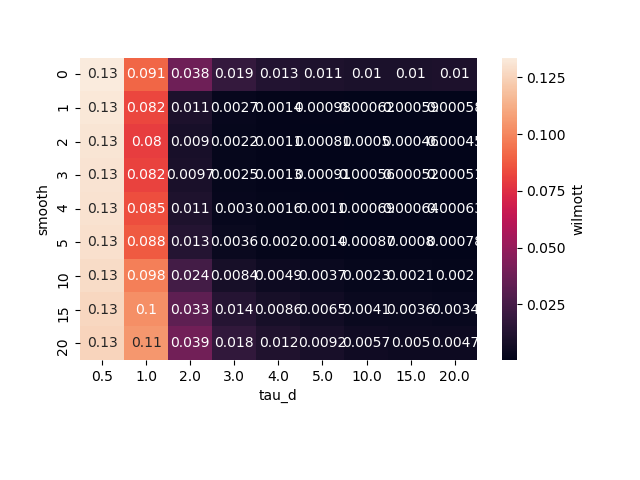

In [71]:
field='wilmott'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

In [47]:
df.head()

,Unnamed: 0,amp,bias,dataset,murphy,r,smooth,spearman_p,spearman_rho,tau,wilmott,tau_d,log_amp
0,0,0.387704,-0.042354,nofiber,-0.140322,0.030880,0,1.837278e-07,0.593923,43200.0,0.126863,0.5,-0.411500
1,1,1.851223,0.079152,nofiber,-3.360459,0.031140,0,4.840416e-08,0.615571,86400.0,0.085346,1.0,0.267459
2,2,5.830883,0.446819,nofiber,-35.233377,0.027322,0,1.190800e-07,0.601139,172800.0,0.028926,2.0,0.765734
3,3,9.203431,0.821644,nofiber,-89.515920,0.023793,0,3.056894e-07,0.585220,259200.0,0.017652,3.0,0.963950
4,4,11.816400,1.158016,nofiber,-149.551927,0.021383,0,5.526421e-07,0.574768,345600.0,0.013901,4.0,1.072485


In [ ]:

# for baseline reference, what concentration do I get
# from this directly?
cell_counts=np.zeros(g.Ncells(),np.float64)
for count,time,rel_time,cell in combined:
    cell_counts[int(cell)]+=count
nsteps=4 # [-2,+2] hours
cell_conc=cell_counts/g.cells_area()/nsteps

In [ ]:
fig=plt.figure()
ax=plt.gca()

clim=[1e-4,100]
ccoll=g.plot_cells(values=cell_conc.clip(clim[0]),
                   norm=LogNorm(vmin=clim[0],vmax=clim[1],clip=True),
                   cmap='jet',ax=ax)
ccoll.set_clim(clim)
ax.axis('equal')

In [ ]:
# relate that back to the sample:
c_select=ptm_set.grid().select_cells_nearest(np.r_[rec.x,rec.y])

stencil=np.zeros(g.Ncells(),np.float64)
stencil[c_select]=1.0
stencil1=ptm_set.smooth(stencil)
conc0=(stencil*cell_conc).sum()
conc1=(stencil1*cell_conc).sum()

print(f"No smoothing, predicted: {conc0:.5f} particles/m2")
print(f"Smoothed, predicted      {conc1:.5f} particles/m2")
print(f"Observed, no-fiber       {rec['part_per_m2_nofiber']:.5f} particles/m2")

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.loglog( obs, pred, 'g.',ms=7 )

ax.set_ylabel('Model')
ax.set_xlabel('Observed')
fig.tight_layout()
fig.savefig('scatter-depression.png',dpi=150)

In [ ]:
pred=manta.apply(lambda rec: extract_for_sample(rec,smooth=10,tau_s=2*86400),
                 axis=1)
obs=manta['part_per_m2_nofiber']

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.loglog( obs, pred, 'g.',ms=7 )

ax.set_ylabel('Model')
ax.set_xlabel('Observed')
fig.tight_layout()
fig.savefig('scatter-betterest.png',dpi=150)

In [ ]:
np.corrcoef(np.log10(obs.clip(1e-5)),
            np.log10(pred.clip(1e-5)))